In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gc
import datetime
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle

import warnings 
warnings.filterwarnings('ignore')

In [2]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import paddle.optimizer as optim
from paddle.io import Dataset, DataLoader

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


### 超参数定义

In [6]:
# DATA_PATH = "data/data79052/"
DATA_PATH = "work/data/"
BATCH_SIZE = 256  # 128
USE_ALL_DATA = False
USE_TIME = True  # 是否使用时间特征

EMB_DIM = 32  # 嵌入维度  16
REDUCE_RATIO = 2  # 先扩大一倍再降回来
MB_NUMS = 3  # MaskBlocks数量  5

In [7]:
# xDeepFM相关参数
CIN_EMB_DIM = 32  # 32
CIN_H_0 = 22  # 原始特征数量
CIN_HK_LIST = [256, 128, 64]  # [100, 100, 50]

In [4]:
def reduce_mem_usage(df, use_uint=True, verbose=True):
    """
    节约内存函数
    :param df: 原始从文件中读取出来的df数据
    :param use_uint: 是否使用无符号整型处理数据
    :param verbose: 是否打印输出处理前后内存占用情况
    :return: 处理后的df
    """
    numerics = ['uint8', 'uint16', 'uint32', 'uint64',
                'int8', 'int16', 'int32', 'int64', 
                'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if 'int' in str(col_type):
                if use_uint and c_min >= 0:  # uint类型
                    if c_max <= np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_max <= np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_max <= np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:  # signed int类型
                    if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)  
            else:  # float类型
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('StartMem:{:.2f}Mb, EndMem:{:.2f}Mb ({:.1f}% reduction)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### 构建 特征种类-嵌入维度 对应关系

In [8]:
# 特征列名称
feat_list = ['android_id', 'media_id', 'package', 'apptype', 'version', 
             'fea_hash', 'fea1_hash', 'cus_type', 'location', 'carrier', 
             'dev_height', 'dev_width', 'dev_ppi', 'lan', 'ntt', 'osv', 'os']  
# 各特征对应种类数
cardi = [467958, 292, 2102, 89, 23, 509473, 6147, 58, 332, 5, 864, 382, 105, 25, 8, 165, 2]
if USE_TIME:
    feat_list.extend(["day", "weekday", "hour", "minute", "second"])
    cardi.extend([8, 7, 24, 60, 60])
# 特征列:种类数 对应字典
cardi_dict = dict(zip(feat_list, cardi))    
# 嵌入维度列表(嵌入维度 = 6 * (原始种类数^0.25))
emb_dim_list = [6 * np.int(np.power(c, 0.25)) for c in cardi]#[EMB_DIM for c in cardi]
# 构建 原始维度:嵌入维度 对应列表
emb_dim_dict = list(zip(cardi, emb_dim_list))  # 每个特征域使用自己的嵌入维度
emb_samedim_dict = list(zip(cardi, [EMB_DIM] * len(cardi)))  # 每个特征域是哟明相同的嵌入维度，便于基于vector-wise的特征交互
# 计算嵌入总维度
EMB_OUT_SIZE = sum(emb_dim_list)         
EMB_SAMEOUT_SIZE = EMB_DIM * len(cardi)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


### 加载训练数据

In [9]:
if USE_TIME: 
    train = pd.read_csv(DATA_PATH + "lbe_raw_train_with_time.csv")
else:
    train = pd.read_csv(DATA_PATH + "lbe_raw_train.csv")
train = reduce_mem_usage(train, use_uint=False)

StartMem:95.37Mb, EndMem:22.89Mb (76.0% reduction)


### 分割训练集和验证集

In [10]:
def getTrain(df, use_all):
    """
    分割训练集和验证集
    :param df:全量训练数据
    :param use_all:是否使用全量训练数据
    :return:训练集特征, 验证集特征, 训练集标签, 验证集标签
    """
    if use_all:
        X_train, X_valid, y_train, y_valid = train[feat_list].values, None, train["label"].values, None
    else:
        X_train, X_valid, y_train, y_valid = train_test_split(train[feat_list].values, 
                                                      train["label"].values, test_size=0.1, random_state=2021)  # 0.1
    
    return X_train, X_valid, y_train, y_valid

In [11]:
X_train, X_valid, y_train, y_valid = getTrain(train, USE_ALL_DATA)

In [14]:
X_all, _, y_all, _ = getTrain(train, True)

### 建立dataset类用于加载数据

In [10]:
class MyDataset(Dataset):
    def __init__(self, data_x, data_y):
        super(MyDataset, self).__init__()
        self.data_x = data_x
        self.data_y = data_y
    
    def __len__(self):
        return self.data_y.shape[0]
    
    def __getitem__(self, idx):
        return self.data_x[idx].astype(np.int), self.data_y[idx]

In [11]:
train_dataset = MyDataset(X_train, y_train)
if not USE_ALL_DATA:
    valid_dataset = MyDataset(X_valid, y_valid)

In [15]:
all_dataset = MyDataset(X_all, y_all)
all_loader = DataLoader(all_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
if not USE_ALL_DATA:
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 模型搭建

### MaskNet(参考[论文链接](https://arxiv.org/pdf/2102.07619v1.pdf))

In [17]:
class IGM(nn.Layer):
    """
    实例指导的Mask模块。分为两层fc，第一层将数据扩大至中间维度，第二层将中间维度投影回原始维度
    :param reduce_r: 中间层缩减比例(原始维度 / 中间层维度)
    :param input_size: 原始输入维度
    """
    def __init__(self, reduce_r, input_size):
        super(IGM, self).__init__()
        
        mid_size = input_size * reduce_r
        self.agg_layer = nn.Linear(input_size, mid_size)  # 先扩大至中间维度
        self.proj_layer = nn.Linear(mid_size, input_size)  # 再降维至原始维度
    
    def forward(self, x):
        x = self.agg_layer(x)
        x = self.proj_layer(x)
        return x

In [18]:
class MaskBlock(nn.Layer):
    """
    MaskBlock，MaskNet的组成部分。每个MaskBlock由一个IGM和一个隐层组成。
    :param emb_out_size: 嵌入层输出总维度
    :param igm_reduce_r: IGM的缩减率
    :param hid_size: 隐层维度，默认为-1，此时隐层维度设置为和嵌入层输出维度相同
    :param mode:MaskBlock的类型，可选参数为'emb'和'mb'
        "emb":MaskBlock on feature embedding
        "mb":MaskBlock on MaskBlock
    """
    def __init__(self, emb_out_size, igm_reduce_r, hid_size=-1, mode="emb"):
        
        super(MaskBlock, self).__init__()
        self.mode = mode  # 用于区分两种不同结构的MaskBlock
        
        # 三个关键部分：LN, IGM, FFH
        if mode == "emb":
            self.LN_EMB = nn.LayerNorm(emb_out_size)
            
        self.IGM = IGM(reduce_r=igm_reduce_r, input_size=emb_out_size)
        
        if hid_size == -1:
            hid_size = emb_out_size
        self.hid_layer = nn.Linear(emb_out_size, hid_size)
        self.LN_HID = nn.LayerNorm(hid_size)
        
    def forward(self, x_left, x_right):
        if self.mode == "emb":
            ln_emb_out = self.LN_EMB(x_left)
        else:
            ln_emb_out = x_left
            
        igm_out = self.IGM(x_right)
        out = F.relu(self.LN_HID(self.hid_layer(ln_emb_out * igm_out)))
        return out

In [19]:
class EmbLayer(nn.Layer):
    """
    嵌入层
    :param emb_dict：list, [(cardi：emb_dim), ...]
    :param concat_axis: 
        -1 -> 横向(形成一个向量)    
        0 -> 纵向(形成一个矩阵)   
        None -> 不拼接，直接返回嵌入list
    return: 各个域嵌入之后的结果
    """
    def __init__(self, emb_dict, concat_axis=-1):
        super(EmbLayer, self).__init__()
        self.field_num = len(emb_dict)
        self.concat_axis = concat_axis
        self.emb_list, self.emb_out_size = self.createEmb_list(emb_dict)
        
    def createEmb_list(self, emb_dict):
        emb_list = nn.LayerList()
        emb_out_size = 0
        for cardi_num, emb_dim in emb_dict:
            emb_list.append(nn.Embedding(cardi_num, emb_dim))
            emb_out_size += emb_dim
        
        return emb_list, emb_out_size
    
    def forward(self, x):
        if self.concat_axis is None:
            return [self.emb_list[i](x[:, i]) for i in range(len(self.emb_list))]
            
        y = paddle.concat([self.emb_list[i](x[:, i]) for i in range(len(self.emb_list))], axis=-1)
        if self.concat_axis != -1:
            y = paddle.reshape(y, shape=[x.shape[0], self.field_num, -1])
        return y

In [20]:
class MLP(nn.Layer):
    """
    MLP层
    :param mlp_size_list: list, MLP各层尺寸
    :param bn: bool, 是否使用batch normalization
    :param drop_out: 0-1/None, 丢弃比例, 默认0.5
    """
    def __init__(self, mlp_size_list, bn=False, drop_out=0.5):
        super(MLP, self).__init__()
        self.bn = bn
        self.drop_out = drop_out
        self.fc_layers = self.createFCLayers(mlp_size_list)
        
    def createFCLayers(self, mlp_size_list):
        fc_layers = nn.LayerList()
        if self.bn:
            self.bn_layers = nn.LayerList()
        if isinstance(self.drop_out, float):
            self.drop_out_layers = nn.LayerList()

        for idx in range(len(mlp_size_list)-1):
            fc_layers.append(nn.Linear(mlp_size_list[idx], mlp_size_list[idx+1]))
            if self.bn:
                self.bn_layers.append(nn.BatchNorm1D(mlp_size_list[idx+1]))
            
            if isinstance(self.drop_out, float):
                self.drop_out_layers.append(nn.Dropout(p=self.drop_out))

        return fc_layers
        

    def forward(self, x):
        for idx, fc in enumerate(self.fc_layers):
            x = fc(x)
            if self.bn:
                x = self.bn_layers[idx](x)
            if isinstance(self.drop_out, float):
                x = self.drop_out_layers[idx](x)
            x = F.relu(x)
        
        return x

In [21]:
class ParaMaskNet(nn.Layer):
    """
    并行结构MaskNet
    :param emb_dict: list, [(原始cardi数量：嵌入维度), ...]
    :param igm_reduce_r_list: 每个MB对应一个IGM, 因此其长度即为MB的数量，每个值为对应的IGM中缩减率
    :param mb_hid_list: 每个MB对应一个hidden层，每个值为对应的隐层数量，如果不单独设置可以全部赋值为-1，此时输出和输入维度相同
    :param mlp_size_list: DNN隐层维度列表
    :param emb_out_size: 嵌入层输出总维度
    :param use_self_emb: 是否使用自己的嵌入层
    :param use_last_fc: 是否使用最后一层全连接
    :return: 并行结构的MaskNet实例
    """
    def __init__(self, emb_dict, igm_reduce_r_list, mb_hid_list, mlp_size_list, emb_out_size=EMB_OUT_SIZE, use_self_emb=True, use_last_fc=True):
        super(ParaMaskNet, self).__init__()
        
        self.emb_out_size = emb_out_size
        self.use_last_fc = use_last_fc

        self.use_self_emb = use_self_emb
        if use_self_emb:
            self.emb_layer = EmbLayer(emb_dict, concat_axis=None)
        
        self.mb_list, self.mb_out_size = self.createMBlist(igm_reduce_r_list, mb_hid_list)
        
        mlp_size_list.insert(0, self.mb_out_size)  # mb层的输出之后即为mlp层
        self.mlp = MLP(mlp_size_list, bn=True, drop_out=0.5)  
        
        self.last_input_dim = mlp_size_list[-1]  # 最后一层fc的输入维度
        if self.use_last_fc:
            self.fc = nn.Linear(self.last_input_dim, 1)
        
    def createMBlist(self, igm_reduce_r_list, mb_hid_list):
        """
        构建MaskBlock模块
        :param igm_reduce_r_list: 每个MB对应的缩减率列表
        :param mb_hid_list: 每个MB对应的隐层维度列表
        :return: 创建好的包含若干MB的LayerList
        """
        mb_list = nn.LayerList()
        mb_out_size = 0  # 统计所有MB模块的总输出维度
        
        for i in range(len(igm_reduce_r_list)):
            mb_list.append(MaskBlock(self.emb_out_size, igm_reduce_r_list[i], mb_hid_list[i]))  # 
            mb_out_size += self.emb_out_size if mb_hid_list[i] == -1 else mb_hid_list[i]
            
        return mb_list, mb_out_size
        
        
    def forward(self, x):
        # 如果使用自己的嵌入层，则将当前数据跑一边自己的嵌入层
        if self.use_self_emb:  
            x = self.emb_layer(x)
        # 此时x默认是未经concat的emb_list，这里进行横向拼接，形成一个长的嵌入向量
        x = paddle.concat(x, axis=-1)  
        # 依次经过MB模块并对结果进行拼接，依旧形成一个长的嵌入向量
        x = paddle.concat([self.mb_list[i](x, x) for i in range(len(self.mb_list))], axis=-1)  
        # 将MB层的输出接入MLP层
        x = self.mlp(x)  
        # 如果使用自身的最后一层则直接出最终计算结果，否则返回最后一层隐层的数据
        if self.use_last_fc:
            x = self.fc(x)
            return F.sigmoid(x)
            
        return x

In [75]:
class ModifyParaMaskNet(nn.Layer):
    """
    对并行MaskNet结构进行改造，原来的模块都是利用基于bit-wise的交互方式，尝试加入vector-wise的交互方式
    emb_dict: 原始cardi数量：嵌入维度
    igm_reduce_r_list: 每个MB对应一个IGM, 因此其长度即为MB的数量，每个值为对应的IGM中缩减率
    mb_hid_list: 每个MB对应一个hidden层，每个值为对应的隐层数量，如果不单独设置可以全部赋值为-1
    mlp_size_list: DNN隐层维度列表
        
    """
    def __init__(self, emb_dict, igm_reduce_r_list, mb_hid_list, cin_hk_list, mlp_size_list, emb_out_size=EMB_OUT_SIZE, use_self_emb=True, use_last_fc=True):
        super(ModifyParaMaskNet, self).__init__()
        
        self.emb_out_size = emb_out_size
        self.use_last_fc = use_last_fc
        
        self.use_self_emb = use_self_emb
        if use_self_emb:
            self.emb_layer = EmbLayer(emb_dict, concat_axis=None)
        
        self.field_num = len(emb_dict)
        self.emb_dim = emb_dict[0][1]

        self.mb_list, self.mb_out_size = self.createMBlist(igm_reduce_r_list, mb_hid_list, self.emb_out_size)
        
        self.cin = CIN(batch_size=BATCH_SIZE, h_0=self.field_num, emb_dim=self.emb_dim, hk_list=cin_hk_list)
        
        mlp_size_list.insert(0, self.mb_out_size)  
        if len(mlp_size_list) > 1:
            self.mlp = MLP(mlp_size_list, bn=True, drop_out=True)
        else:
            self.mlp = None

        self.last_input_dim = mlp_size_list[-1] + self.cin.cin_out_size + self.emb_out_size
        if self.use_last_fc:
            self.fc = nn.Linear(self.last_input_dim, 1)
        
    def createMBlist(self, igm_reduce_r_list, mb_hid_list, input_size):
        mb_list = nn.LayerList()
        mb_out_size = 0
        
        for i in range(len(igm_reduce_r_list)):
            mb_list.append(MaskBlock(input_size, igm_reduce_r_list[i], mb_hid_list[i]))  # 
            mb_out_size += input_size if mb_hid_list[i] == -1 else mb_hid_list[i]
            
        return mb_list, mb_out_size
        
        
    def forward(self, x):
        if self.use_self_emb:
            x = self.emb_layer(x)
        # 此时x默认是未经concat的emb_list
        x = paddle.concat(x, axis=-1)
        
        cin_in = paddle.reshape(x, shape=[x.shape[0], self.field_num, self.emb_dim])  # batch_size * field_num * emb_dim
        cin_out = self.cin(cin_in)
        pmb_out = paddle.concat([self.mb_list[i](x, x) for i in range(len(self.mb_list))], axis=-1)
              
        # x = paddle.concat([x_pm, cin_out], axis=-1)
        if self.mlp is not None:
            mlp_out = self.mlp(pmb_out)
        else:
            mlp_out = pmb_out
            
        x = paddle.concat([x, cin_out, mlp_out], axis=-1)
        if self.use_last_fc:
            x = self.fc(x)
            return F.sigmoid(x)
            
        return x

In [32]:
EMB_OUT_SIZE

654

In [33]:
class SerMaskNet(nn.Layer):
    """
    序列MaskNet，类似于RNN的结构
    :param emb_dict: [(原始种类数, 嵌入维度),...]
    :param igm_reduce_r_list: list, 每个MB对应的缩减率
    :param mb_hid_list: list, 每个MB对应的隐层维度
    :param mlp_size_list: list, MLP各层尺寸
    :param emb_out_size: 嵌入层输出总维度
    :param use_self_emb: 是否使用自己的嵌入层
    :param use_last_fc: 是否使用最后一层fc
    :return: 
    """
    def __init__(self, emb_dict, igm_reduce_r_list, mb_hid_list, mlp_size_list, emb_out_size=EMB_OUT_SIZE, use_self_emb=True, use_last_fc=True):
        super(SerMaskNet, self).__init__()
        
        self.emb_out_size = emb_out_size
        self.use_last_fc = use_last_fc

        self.use_self_emb = use_self_emb
        if use_self_emb:
            self.emb_layer = EmbLayer(emb_dict, concat_axis=None)

        self.mb_list, self.mb_out_size = self.createMBlist(igm_reduce_r_list, mb_hid_list)
        
        mlp_size_list.insert(0, self.mb_out_size)  # mb层的输出
        if len(mlp_size_list) > 1:
            self.mlp = MLP(mlp_size_list, bn=True, drop_out=0.5)
        else:
            self.mlp = None

        # 记录最后一层输入维度
        self.last_input_dim = mlp_size_list[-1]
        if self.use_last_fc:
            self.fc = nn.Linear(self.last_input_dim, 1)
    
    def createMBlist(self, igm_reduce_r_list, mb_hid_list):
        mb_list = nn.LayerList()
        
        for i in range(len(igm_reduce_r_list)):
            if i == 0:  # 第一个MaskBlock是MaskBlock on Feature Embedding
                mb_list.append(MaskBlock(self.emb_out_size, igm_reduce_r_list[i], mb_hid_list[i], mode="emb"))
            else:  # 其余MaskBlock都是MaskBlock on MaskBlock
                mb_list.append(MaskBlock(self.emb_out_size, igm_reduce_r_list[i], mb_hid_list[i], mode="mb"))  # 
            
        return mb_list, mb_hid_list[-1]

    
    def forward(self, x):
        if self.use_self_emb:
            x = self.emb_layer(x)
        # 此时x是尚未concat的emb list
        x = paddle.concat(x, axis=-1)

        x_left = x  # 左边部分是上一个MB的输出
        x_right = x  # 右边部分是原始emb层的输出
        for i in range(len(self.mb_list)):
            x_left = self.mb_list[i](x_left, x_right)
        
        if self.mlp is not None:
            x = self.mlp(x_left)
        else:
            x = x_left
        
        if self.use_last_fc:
            x = self.fc(x)
            return F.sigmoid(x)

        return x
        

In [ ]:
# 使用共同的embedding层，每个模型都可以修改
# 取出每个模型最后的隐层参数，然后concat之后进行fc

In [22]:
class EnsembleModel(paddle.nn.Layer):
    def __init__(self, emb_dim_dict=emb_dim_dict):
        super(EnsembleModel, self).__init__()
        self.use_self_emb = False  # 是否使用各自自己的emb层
        if not self.use_self_emb:
            self.emb_layer = EmbLayer(emb_dim_dict, concat_axis=None)

        self.model_list = nn.LayerList([
                            ParaMaskNet(emb_dict=emb_dim_dict, igm_reduce_r_list=[1, 2, 3], mb_hid_list=[512 * i for i in range(1, 4)], 
                                        mlp_size_list=[512, 128], emb_out_size=EMB_OUT_SIZE, use_self_emb=self.use_self_emb, use_last_fc=False), 
                            # DeepFM(emb_dict=emb_dim_dict, mlp_size_list=mlp_size_list, emb_out_size=EMB_OUT_SIZE, use_self_emb=self.use_self_emb, use_last_fc=False),
                            SerMaskNet(emb_dict=emb_dim_dict, igm_reduce_r_list=[1, 2, 3], mb_hid_list=[-1, -1, 512], 
                                        mlp_size_list=[128], emb_out_size=EMB_OUT_SIZE, use_self_emb=self.use_self_emb, use_last_fc=False)
                          ])
        # 还要获取最后一层拼接之后的维度
        last_input_dim = sum([m.last_input_dim for m in self.model_list])
        self.fc = nn.Linear(last_input_dim, 1)


    def forward(self, x):
        if not self.use_self_emb:
            x = self.emb_layer(x)
        
        out_list = [m(x) for m in self.model_list]
        out = paddle.concat(out_list, axis=-1)
        out = self.fc(out)
        return F.sigmoid(out)

### xDeepFM

In [76]:
class CIN(paddle.nn.Layer):
    def __init__(self, batch_size, h_0, emb_dim, hk_list=[100, 100, 50]):
        super(CIN, self).__init__()
        self.batch_size = batch_size
        self.h_0 = h_0
        self.emb_dim = emb_dim
        self.hk_list = hk_list
        self.wk_list, self.cin_out_size = self.create_cross_ws()
        
    def create_cross_ws(self):
        cin_out_size = 0
        # 创建对应每一层的权重(也就是滤波器)
        self.hk_list.insert(0, self.h_0)
        wk_list = paddle.nn.ParameterList()
        for k in range(1, len(self.hk_list)):
            w_k = paddle.static.create_parameter(shape=[self.hk_list[k-1] * self.h_0, self.hk_list[k]], 
                                                dtype="float32")#, 
                                                #default_initializer=paddle.nn.initializer.Constant(1.0))
            wk_list.append(w_k)
            cin_out_size += self.hk_list[k]
        return wk_list, cin_out_size
    
    def forward(self, x):
        x_0 = x  # 原始输入
        xk_list = [x_0]  # x_k各层的计算结果
        sum_pool_list = []  # x_K各层的sum_pooling结果, 不包括第一层
        # 分割原始输入
        split_x_0 = paddle.split(x_0, self.emb_dim, axis=-1)
        # 计算x_k
        for k in range(len(self.hk_list)-1):
            # 取出x(k-1)
            x_km1 = xk_list[-1]
            # 分割x(k-1)
            split_x_km1 = paddle.split(x_km1, self.emb_dim, -1)
            # 计算x(k-1) 与 x(0)的外积 -> zk
            z_k = paddle.concat([paddle.matmul(split_x_km1[i], split_x_0[i], transpose_y=True).unsqueeze(0) 
                                                for i in range(self.emb_dim)], axis=0)  # emb_dim * batch_size * h_km1 * h_0
            z_k = paddle.transpose(z_k, perm=[1, 0, 2, 3])  # batch_size * emb_dim * h_km1 * h_0
            # 将zk最后两维拉成一维
            z_k = paddle.reshape(z_k, shape=[z_k.shape[0], self.emb_dim, -1])  # batch_size * emb_dim * (h_km1 * h_0)
            # 计算x_k = w * z_k
            x_k = paddle.matmul(z_k, self.wk_list[k])  # batch_size * emb_dim * h_k
            # 转置为正常形状
            x_k = paddle.transpose(x_k, perm=[0, 2, 1])  # batch_size * h_k * emb_dim
            # 存储x_k
            xk_list.append(x_k)
            # 计算sum_pooling
            sum_pool_list.append(paddle.sum(x_k, axis=-1))
            #print(x_k.shape)
        
        # concat sum_pooling的结果
        return paddle.concat(sum_pool_list, axis=-1)

In [ ]:
class xDeepFM(nn.Layer):
    def __init__(self, batch_size, emb_dict, emb_dim, cin_hk_list, mlp_size_list):
        super(xDeepFM, self).__init__()
        self.emb_layer = EmbLayer(emb_dict)
        self.field_num = len(emb_dict)
        self.batch_size = batch_size
        self.emb_dim = emb_dim
        self.cin = CIN(batch_size=batch_size, h_0=self.field_num, emb_dim=emb_dim, hk_list=cin_hk_list)

        # 嵌入总维度 = 域数量 * 单个嵌入维度
        mlp_size_list.insert(0, self.emb_layer.emb_out_size)  # 域数量 * 嵌入维度
        self.mlp = MLP(mlp_size_list, bn=True, drop_out=True)
        self.fc = nn.Linear(self.emb_layer.emb_out_size + self.cin.cin_out_size + mlp_size_list[-1], 1)
    
    def forward(self, x):
        x = self.emb_layer(x)  # batch_size * (field_num * emb_dim)
        # 将原始一维嵌入转换为二维的形式
        cin_in = paddle.reshape(x, shape=[x.shape[0], self.field_num, self.emb_dim])  # batch_size * field_num * emb_dim
        # 计算cin的输出
        cin_out = self.cin(cin_in)
        # 计算mlp的输出
        mlp_out = self.mlp(x)
        # 拼接 原始嵌入 CIN MLP
        x = paddle.concat([x, cin_out, mlp_out], axis=-1)
        x = F.sigmoid(self.fc(x))
        return x


In [ ]:
emb_dict =  list(zip(cardi, [6 * np.int(np.power(c, 0.25)) for c in cardi]))

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [ ]:
class PlainDNN(nn.Layer):
    def __init__(self, emb_dict, emb_dim, mlp_size_list):
        super(PlainDNN, self).__init__()
        self.emb_layer = EmbLayer(emb_dict, concat_axis=None)
        mlp_size_list.insert(0, self.emb_layer.emb_out_size)
        self.mlp = MLP(mlp_size_list, bn=True, drop_out=True)
        self.fc = nn.Linear(mlp_size_list[-1], 1)
    
    def forward(self, x):
        x = self.emb_layer(x)
        x = paddle.concat(x, axis=-1)
        x = self.mlp(x)
        x = F.sigmoid(self.fc(x))
        return x

### DeepFM

In [ ]:
class DeepFM(nn.Layer):
    def __init__(self, emb_dict, mlp_size_list, emb_out_size=EMB_OUT_SIZE, use_self_emb=True, use_last_fc=True):
        super(DeepFM, self).__init__()
        
        self.use_self_emb = use_self_emb
        self.use_last_fc = use_last_fc
        # embedding
        feat_num = len(emb_dict)
        if self.use_self_emb:
            self.emb_layer = EmbLayer(emb_dict, concat_axis=None)

        self.cross_w_list = nn.ParameterList([paddle.static.create_parameter(shape=[1, 32], dtype="float32")] * feat_num)  # 为每个特征域生成一个对应的可学习参数，用于交叉
        self.emb_out_size = emb_out_size

        self.sum_w_list = nn.ParameterList([paddle.static.create_parameter(shape=[1, 1], dtype="float32")] * 
                                          ((feat_num * (feat_num-1))//2 + feat_num))
        # mlp
        mlp_size_list.insert(0, self.emb_out_size)
        self.mlp = MLP(mlp_size_list, bn=True, drop_out=True)
        
        # print(self.emb_out_size)
        self.last_input_dim = self.emb_out_size//feat_num + mlp_size_list[-1]
        # 拼接fm和mlp
        if self.use_last_fc:
            self.fc = nn.Linear(self.last_input_dim, 1)
        
    def crossFeats(self, emb_out_list):
        cross_out_list = []
        # 对应位置权重相乘
        for i in range(len(emb_out_list)):
            for j in range(i+1, len(emb_out_list)):
                cross_out_list.append(self.cross_w_list[i].dot(self.cross_w_list[j]) * emb_out_list[i] * emb_out_list[j])
        return cross_out_list
    
    def sumFeats(self, cross_list):
        out = paddle.zeros_like(cross_list[0])
        for i in range(len(cross_list)):
            out += self.sum_w_list[i] * cross_list[i]
        return out
    
    def forward(self, x):
        # 对所有特征进行依次嵌入
        if self.use_self_emb:
            emb_out_list = self.emb_layer(x)
        else:  # 如果不使用自己的emb层，公用层输出默认就是emb之后的List
            emb_out_list = x

        # 计算二阶特征交叉，返回交叉后的List
        cross_out_list = self.crossFeats(emb_out_list)
        # 将所有交叉过的2阶特征和原始1阶特征concat
        #shallow_out = paddle.concat(emb_out_list + cross_out_list, axis=1)
        # 将一阶特征(原始emb输出)和二阶交叉list拼接之后求和
        shallow_out = self.sumFeats(emb_out_list + cross_out_list)  # bz * (n + (n-1)*n/2) * emb_dim -> bz * emb_dim
        
        # DNN输出
        deep_out = self.mlp(paddle.concat(emb_out_list, axis=1))
        
        out = paddle.concat([shallow_out, deep_out], axis=-1)
        
        if self.use_last_fc:
            out = self.fc(out)
            return F.sigmoid(out)
        # 如果不使用最后一层fc，则直接把当前模型训练的最后一个隐层输出，用于模型融合
        return out

### DeepFFM

In [ ]:
class DeepFFM(nn.Layer):
    def __init__(self, cardi_dict, emb_dim, dnn_list):
        super(DeepFFM, self).__init__()
        
        self.cardi_dict = cardi_dict
        self.emb_layers = nn.LayerList()
        self.cross_w_list = nn.ParameterList()
        
        self.emb_dim_sum = self.createEmbeddingLayers(emb_dim)
        
        dnn_list.insert(0, self.emb_dim_sum)
        self.mlp = MLP(dnn_list, bn=True, drop_out=True)
        feat_num = len(cardi_dict)
        self.sum_w_list = nn.ParameterList([paddle.static.create_parameter(shape=[1, 1], dtype="float32")] * 
                                          (np.int(np.power(feat_num-1, 2)) + feat_num))
        #last_dim = np.int(np.power(feat_num-1, 2)) * emb_dim + feat_num * emb_dim + dnn_list[-1]
        last_dim = emb_dim + dnn_list[-1]
        self.fc = nn.Linear(last_dim, 1)
        
    def createEmbeddingLayers(self, emb_dim):
        emb_dim_sum = 0
        for feat in feat_list:
            cardi = self.cardi_dict[feat]
            self.emb_layers.append(nn.Embedding(cardi, emb_dim))
            # 每个特征域对应一个权重矩阵: emb_dim * m
            w_dim = 16
            self.cross_w_list.append(paddle.static.create_parameter(shape=[emb_dim, w_dim], dtype="float32"))  
            emb_dim_sum += emb_dim
        
        return emb_dim_sum
    
    def crossFeats(self, emb_out_list):
        cross_out_list = []
        # 对应位置权重相乘
        for i in range(len(emb_out_list)):
            for j in range(len(emb_out_list)):
                if i == j: 
                    break
                hadma_prod = emb_out_list[i] * emb_out_list[j]
                w_prod = paddle.matmul(self.cross_w_list[i], self.cross_w_list[j], transpose_y=True)
                w_emb_prod = paddle.matmul(w_prod, hadma_prod, transpose_y=True)
                cross_out_list.append(paddle.transpose(w_emb_prod, perm=[1, 0]))
        return cross_out_list
    
    def sumFeats(self, cross_list):
        out = paddle.zeros_like(cross_list[0])
        for i in range(len(cross_list)):
            out += self.sum_w_list[i] * cross_list[i]
        return out
    
    def forward(self, x):
        # 对所有特征进行依次嵌入
        emb_out_list = [self.emb_layers[i](x[:, i]) for i in range(len(self.emb_layers))]
        # 对所有特征进行交叉
        cross_out_list = self.crossFeats(emb_out_list)
        # 将所有交叉过的2阶特征和原始1阶特征concat
        #shallow_out = paddle.concat(emb_out_list + cross_out_list, axis=1)
        shallow_out = self.sumFeats(emb_out_list + cross_out_list)  # bz * 64
        
        # DNN输出
        deep_out = self.mlp(paddle.concat(emb_out_list, axis=1))
        
        out = paddle.concat([shallow_out, deep_out], axis=-1)
        
        out = self.fc(out)
        return F.sigmoid(out)

### 模型实例化

In [ ]:
model_dffm = DeepFFM(cardi_dict=cardi_dict, emb_dim=64, dnn_list=[512, 256, 64])

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [ ]:
mlp_size_list = [512, 256, 64]#[400, 400, 400]#[512, 256, 64] 倒金字塔结构效果要稍微比全相同结构效果好点

In [ ]:
EMB_OUT_SIZE

704

In [ ]:
model_dfm = DeepFM(emb_dict=emb_dim_dict, mlp_size_list=[512, 256, 64], emb_out_size=EMB_OUT_SIZE, use_self_emb=True, use_last_fc=True)
#model_dfm = DeepFM(cardi_dict=cardi_dict, emb_dim=64, dnn_list=[512, 256, 64])
#optimizer = optim.Adam(parameters=model_dfm.parameters(), learning_rate=0.01, weight_decay=0.01)

In [ ]:
model_xdfm = xDeepFM(batch_size=BATCH_SIZE, 
                    emb_dict=emb_dim_dict, 
                    emb_dim=CIN_EMB_DIM, 
                    cin_hk_list=CIN_HK_LIST, 
                    mlp_size_list=[512, 256, 64])#[256, 256, 32])#[512, 256, 64])#[128, 256, 64])

In [ ]:
igm_reduce_r_list = [i for i in range(1, MB_NUMS+1)]
mlp_size_list=[512, 256, 64]#[400, 400, 400]#[512, 256, 64]  # [400, 400, 400]

In [ ]:
EMB_OUT_SIZE

704

In [ ]:
model_pmb = ParaMaskNet(emb_dict=emb_dim_dict, 
                        igm_reduce_r_list=[1, 2, 3], 
                        mb_hid_list=[512, 512, 512], 
                        mlp_size_list=[512, 256, 64])

In [ ]:
model_smb = SerMaskNet(emb_dict=emb_dim_dict, 
                        igm_reduce_r_list=igm_reduce_r_list, 
                        mb_hid_list=[-1] * MB_NUMS, 
                        mlp_size_list=mlp_size_list)

In [ ]:
model_ensem = EnsembleModel(emb_dim_dict)

### 定义模型训练函数

In [26]:
def getTrue(a, b):
    res = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            res += 1
    return res

In [27]:
def validation(model, loss_fn, data_loader, mode="valid"):
    model.eval()
    acc = 0
    loss_ave = 0
    for idx, (x, y) in enumerate(data_loader):
        y = y.numpy()
        x = paddle.to_tensor(x)
        y = paddle.to_tensor(y, dtype="float32")
        y_pre = model(x)
        y_pre = y_pre.squeeze(-1)
        loss = loss_fn(y_pre, y)
        loss_ave += loss.numpy()[0]
        a = y_pre.numpy()
        a = list(map(lambda x: 1 if x >= 0.5 else 0, a))
        b = y.numpy()
        b = list(map(lambda x: np.int(x), b))
        acc += getTrue(a, b)
    acc /= len(data_loader) * BATCH_SIZE
    loss_ave /= len(data_loader) * BATCH_SIZE
    print(mode + f":loss_ave:{loss_ave}, acc:{acc}")
    model.train()
    return acc

In [28]:
def trainModel(model, loss_fn, optimizer, device, data_loader, start_epoch=0, epoches=10, model_name="DNN", start_save_acc=0.8801, use_all_data=USE_ALL_DATA):
    print(device)
    paddle.set_device(device)
    model.train()
    loss_list = []
    loss_min = 9999
    acc_list = []
    acc_max = start_save_acc
    #for epoch in range(epoches):
    for epoch in range(start_epoch, start_epoch + epoches):
        epoch_ave_loss = 0
        for idx, (x, y) in enumerate(data_loader):
            y = y.numpy()
            x = paddle.to_tensor(x)
            y = paddle.to_tensor(y, dtype="float32")
            y_pre = model(x)
            y_pre = y_pre.squeeze(-1)
            loss = loss_fn(y_pre, y)
            
            epoch_ave_loss += loss.numpy()[0]
            if idx % 500 == 0:
                print(f"epoch:{epoch}, idx:{idx}, batch_sum_loss:{loss.numpy()[0]}")

            loss.backward()
            optimizer.step()
            optimizer.clear_grad()
        
        epoch_ave_loss /= len(data_loader) * BATCH_SIZE
        loss_list.append(epoch_ave_loss)
        print(f"epoch:{epoch}, ave_loss:{epoch_ave_loss}")
        
        

        # 计算训练集准确率
        train_acc = validation(model, loss_fn, data_loader, mode="train")
        
        if not use_all_data:
            acc = validation(model, loss_fn, valid_loader)
            acc_list.append(acc)
            if acc > acc_max:
                acc_max = acc
                paddle.save(model.state_dict(), "./work/" + model_name + "_acc_epoch" + str(epoch) + ".pdparams")
        else:
            if epoch_ave_loss < loss_min:
                loss_min = epoch_ave_loss
                paddle.save(model.state_dict(), "./work/" + model_name + "_loss_epoch" + str(epoch) + ".pdparams")
        print("-------------------------------------------------------------------")
        
        if epoch_ave_loss < 0.27:
            print("Early Stopping!")
            return loss_list, acc_list

    return loss_list, acc_list
            

### 模型训练

In [29]:
loss_fn = nn.BCELoss(reduction="sum")
device = paddle.get_device()

In [ ]:
# model_param = paddle.load("./work/dfm_acc_epoch2_8834.pdparams")
# model_dfm.set_state_dict(model_param)
optimizer = optim.Adam(parameters=model_dfm.parameters(), learning_rate=0.001, weight_decay=0.01)
loss_list, acc_list = trainModel(model_dfm, loss_fn, optimizer, device, train_loader, start_epoch=3, epoches=20, model_name="dfm", start_save_acc=0.884)

gpu:0
epoch:3, idx:0, batch_sum_loss:44.73744583129883


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


epoch:3, idx:500, batch_sum_loss:34.55804443359375
epoch:3, idx:1000, batch_sum_loss:31.3226375579834
epoch:3, idx:1500, batch_sum_loss:38.73979568481445
epoch:3, ave_loss:0.13989192146523957


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


valid_loss_ave:0.3035193509137144, acc:0.8828523596938775
-------------------------------------------------------------------
epoch:4, idx:0, batch_sum_loss:37.36035919189453
epoch:4, idx:500, batch_sum_loss:23.54827117919922
epoch:4, idx:1000, batch_sum_loss:22.998573303222656


KeyboardInterrupt: 

In [48]:
model_ensem = EnsembleModel(emb_dim_dict=emb_dim_dict)
# model_param = paddle.load("./work/ens_pds_loss_epoch17.pdparams")
model_ensem.set_state_dict(model_param)
optimizer = optim.Adam(parameters=model_ensem.parameters(), learning_rate=0.001, weight_decay=0.01)
loss_list, acc_list = trainModel(model_ensem, loss_fn, optimizer, device, train_loader, start_epoch=1, epoches=20, model_name="ens_pds", start_save_acc=0, use_all_data=Fa)

gpu:0
epoch:21, idx:0, batch_sum_loss:76.312255859375


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` he

epoch:21, idx:500, batch_sum_loss:70.6458969116211
epoch:21, idx:1000, batch_sum_loss:83.3962173461914
epoch:21, idx:1500, batch_sum_loss:77.32967376708984
epoch:21, ave_loss:0.276159700196896


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


train:loss_ave:0.27005983539356515, acc:0.8973719773541453
-------------------------------------------------------------------
epoch:22, idx:0, batch_sum_loss:79.58964538574219
epoch:22, idx:500, batch_sum_loss:59.79456329345703
epoch:22, idx:1000, batch_sum_loss:74.67666625976562
epoch:22, idx:1500, batch_sum_loss:66.36986541748047
epoch:22, ave_loss:0.2736798601793154
train:loss_ave:0.2682259527641323, acc:0.8982056038894575
-------------------------------------------------------------------
epoch:23, idx:0, batch_sum_loss:77.4429931640625
epoch:23, idx:500, batch_sum_loss:69.73820495605469
epoch:23, idx:1000, batch_sum_loss:69.97480010986328
epoch:23, idx:1500, batch_sum_loss:75.87858581542969
epoch:23, ave_loss:0.27168930376457584
train:loss_ave:0.26387052942818545, acc:0.9008864028915046
-------------------------------------------------------------------
epoch:24, idx:0, batch_sum_loss:84.5690689086914
epoch:24, idx:500, batch_sum_loss:37.56404113769531
epoch:24, idx:1000, batch_s

In [ ]:
EMB_OUT_SIZE

654

In [74]:
# model_pmb = ParaMaskNet(emb_dict=emb_dim_dict, 
#                         igm_reduce_r_list=[1, 2, 3], 
#                         mb_hid_list=[256, 512, 768], 
#                         mlp_size_list=[512])
model_param = paddle.load("./work/pmb_acc_epoch15_8869.pdparams")
model_pmb.set_state_dict(model_param)
optimizer = optim.Adam(parameters=model_pmb.parameters(), learning_rate=0.0001, weight_decay=0.01)
loss_list, acc_list = trainModel(model_pmb, loss_fn, optimizer, device, train_loader, start_epoch=16, epoches=10, model_name="pmb", start_save_acc=0.887, use_all_data=False)
# loss_list, acc_list = trainModel(model_pmb, loss_fn, optimizer, device, valid_loader, start_epoch=1, epoches=2, model_name="pmb", start_save_acc=0.88)

gpu:0
epoch:16, idx:0, batch_sum_loss:61.516822814941406


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` he

epoch:16, idx:500, batch_sum_loss:51.78311538696289
epoch:16, idx:1000, batch_sum_loss:58.714622497558594
epoch:16, idx:1500, batch_sum_loss:73.0323486328125
epoch:16, ave_loss:0.2697332961838671


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


train:loss_ave:0.26406918475414976, acc:0.8992996302616609
valid:loss_ave:0.2944936845831725, acc:0.8865393813775511
-------------------------------------------------------------------
Early Stopping!


In [ ]:
paddle.save(model_pmb.state_dict(), "./work/pmb_879" + ".pdparams")

In [55]:
# model_smb = ParaMaskNet(emb_dict=emb_dim_dict, 
#                         igm_reduce_r_list=[1, 2, 3], 
#                         mb_hid_list=[-1, -1, 512], 
#                         mlp_size_list=[128])
model_param = paddle.load("./work/smb_loss_epoch10.pdparams")
model_smb.set_state_dict(model_param)
optimizer = optim.Adam(parameters=model_smb.parameters(), learning_rate=0.0001, weight_decay=0.01)
loss_list, acc_list = trainModel(model_smb, loss_fn, optimizer, device, train_loader, start_epoch=11, epoches=5, model_name="smb", start_save_acc=0)
# loss_list, acc_list = trainModel(model_pmb, loss_fn, optimizer, device, valid_loader, start_epoch=1, epoches=2, model_name="pmb", start_save_acc=0.88)                       

gpu:0
epoch:11, idx:0, batch_sum_loss:68.77133178710938


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` he

epoch:11, idx:500, batch_sum_loss:74.66376495361328
epoch:11, idx:1000, batch_sum_loss:68.3926010131836
epoch:11, idx:1500, batch_sum_loss:67.22955322265625
epoch:11, ave_loss:0.2755413932092831


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


train:loss_ave:0.2665813494084771, acc:0.8992211489252815
-------------------------------------------------------------------
epoch:12, idx:0, batch_sum_loss:74.54212188720703
epoch:12, idx:500, batch_sum_loss:62.368614196777344
epoch:12, idx:1000, batch_sum_loss:57.9099235534668
epoch:12, idx:1500, batch_sum_loss:76.84490966796875
epoch:12, ave_loss:0.24715328806803438
train:loss_ave:0.1671947797554466, acc:0.9479473196008188
-------------------------------------------------------------------
Early Stopping!


In [88]:
model_mpmb = ModifyParaMaskNet(emb_dict=emb_samedim_dict, 
                        igm_reduce_r_list=[1, 2, 3], 
                        mb_hid_list=[256, 512, 768], 
                        cin_hk_list=[128, 128, 64],
                        mlp_size_list=[256],
                        emb_out_size=EMB_SAMEOUT_SIZE)
# model_param = paddle.load("./work/pmb_acc_epoch15_8869.pdparams")
# model_mpmb.set_state_dict(model_param)
optimizer = optim.Adam(parameters=model_mpmb.parameters(), learning_rate=0.001, weight_decay=0.01)
loss_list, acc_list = trainModel(model_mpmb, loss_fn, optimizer, device, train_loader, start_epoch=1, epoches=10, model_name="mpmb", start_save_acc=0.886, use_all_data=False)

gpu:0
epoch:1, idx:0, batch_sum_loss:179.44302368164062


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` he

epoch:1, idx:500, batch_sum_loss:83.90325927734375
epoch:1, idx:1000, batch_sum_loss:74.12667846679688
epoch:1, idx:1500, batch_sum_loss:90.74762725830078
epoch:1, ave_loss:0.3068562645350707


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


train:loss_ave:0.28122092282507605, acc:0.8957400099544938
valid:loss_ave:0.2947523988479254, acc:0.8838687818877551
-------------------------------------------------------------------
epoch:2, idx:0, batch_sum_loss:58.34437942504883
epoch:2, idx:500, batch_sum_loss:253.88067626953125
epoch:2, idx:1000, batch_sum_loss:63.21255111694336
epoch:2, idx:1500, batch_sum_loss:62.499237060546875
epoch:2, ave_loss:0.27252886153596523
train:loss_ave:0.11830356762457354, acc:0.9581622404721274
valid:loss_ave:0.2920865372811653, acc:0.8861407844387755
-------------------------------------------------------------------
epoch:3, idx:0, batch_sum_loss:25.031949996948242
epoch:3, idx:500, batch_sum_loss:3.4534337520599365
epoch:3, idx:1000, batch_sum_loss:19.38315200805664
epoch:3, idx:1500, batch_sum_loss:9.734344482421875
epoch:3, ave_loss:0.04545383344894959
train:loss_ave:0.011859934718946188, acc:0.9970736454778157
valid:loss_ave:0.34348469273168214, acc:0.8719308035714286
-----------------------

In [ ]:
model_param = paddle.load("./work/ens_pds_acc_epoch11_8850.pdparams")
model_ensem.set_state_dict(model_param)

In [ ]:
model_param = paddle.load("./work/ens_ps_acc_epoch33_8872.pdparams")
model_ensem.set_state_dict(model_param)
optimizer = optim.Adam(parameters=model_ensem.parameters(), learning_rate=0.00001, weight_decay=0.01)
loss_list, acc_list = trainModel(model_ensem, loss_fn, optimizer, device, train_loader, start_epoch=33, epoches=20, model_name="ens_ps", start_save_acc=0.8872)

gpu:0
epoch:33, idx:0, batch_sum_loss:40.37668228149414


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` he

epoch:33, idx:500, batch_sum_loss:44.81654739379883
epoch:33, idx:1000, batch_sum_loss:37.065853118896484
epoch:33, idx:1500, batch_sum_loss:37.669883728027344
epoch:33, idx:2000, batch_sum_loss:42.260440826416016
epoch:33, idx:2500, batch_sum_loss:27.230144500732422
epoch:33, idx:3000, batch_sum_loss:36.9178581237793
epoch:33, idx:3500, batch_sum_loss:41.12592315673828
epoch:33, ave_loss:0.2936027578297532


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


valid_loss_ave:0.2951925071837652, acc:0.8871283567774936
-------------------------------------------------------------------
epoch:34, idx:0, batch_sum_loss:29.279850006103516
epoch:34, idx:500, batch_sum_loss:37.04157257080078
epoch:34, idx:1000, batch_sum_loss:54.20576095581055
epoch:34, idx:1500, batch_sum_loss:49.444889068603516
epoch:34, idx:2000, batch_sum_loss:36.44204330444336
epoch:34, idx:2500, batch_sum_loss:40.47740936279297
epoch:34, idx:3000, batch_sum_loss:32.983436584472656
epoch:34, idx:3500, batch_sum_loss:24.201622009277344
epoch:34, ave_loss:0.2930525503289781
valid_loss_ave:0.29500971646869883, acc:0.8869085677749361
-------------------------------------------------------------------
epoch:35, idx:0, batch_sum_loss:49.15219497680664
epoch:35, idx:500, batch_sum_loss:38.6931266784668
epoch:35, idx:1000, batch_sum_loss:29.52236557006836
epoch:35, idx:1500, batch_sum_loss:37.406097412109375
epoch:35, idx:2000, batch_sum_loss:38.271324157714844
epoch:35, idx:2500, bat

KeyboardInterrupt: 

In [ ]:
with open("./work/loss_list.pkl", "wb") as f:
    pickle.dump(loss_list, f)

with open("./work/acc_list.pkl", "wb") as f:
    pickle.dump(acc_list, f)

### 绘制损失及ACC变化曲线

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


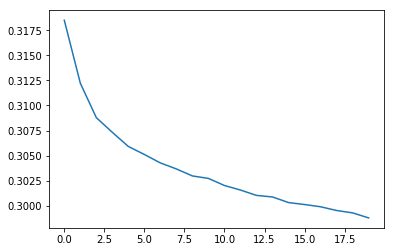

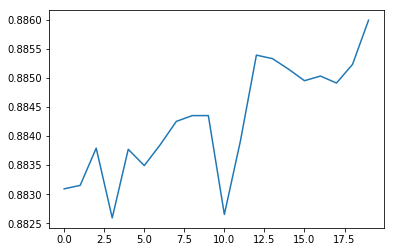

In [ ]:
plt.figure()
plt.plot(loss_list)
plt.show()
plt.plot(acc_list)
plt.show()

### 读取测试集数据并进行推断

In [36]:
USE_TIME = True

In [37]:
if USE_TIME:
    test = pd.read_csv(DATA_PATH + "lbe_raw_test_with_time.csv")
else:
    test = pd.read_csv(DATA_PATH + "lbe_raw_test.csv")
test = reduce_mem_usage(test, use_uint=False)

StartMem:28.61Mb, EndMem:6.87Mb (76.0% reduction)


In [38]:
X_test = test[feat_list].values

In [39]:
def predict(model, data):
    data = paddle.to_tensor(data)
    y_pre = model(data)
    y_pre = y_pre.squeeze(-1)
    return y_pre.numpy()

In [40]:
def getYtest(model, data):
    # 分割一下data
    data_list = []
    # 每块大小变更为batch_size, 然后统一装到list中
    i = 0
    while i <= data.shape[0]:
        data_list.append(data[i:i+BATCH_SIZE])
        i += BATCH_SIZE
    # 按块预测，然后再拼接结果
    y_test_pre = predict(model, data_list[0])
    for d in data_list[1:]:
        y_test_pre = np.append(y_test_pre, predict(model, d))

    #y_test_pre = predict(model, data)
    y_test_label = list(map(lambda x: 1 if x >= 0.5 else 0, y_test_pre))
    return y_test_pre, y_test_label

In [61]:
model_param = paddle.load("./work/ens_pds_loss_epoch17.pdparams")
model_ensem.set_state_dict(model_param)

In [56]:
model_param = paddle.load("./work/smb_loss_epoch11.pdparams")
model_smb.set_state_dict(model_param)

In [62]:
y_test_pre, y_test_label = getYtest(model_ensem, X_test)

In [57]:
y_test_pre, y_test_label = getYtest(model_smb, X_test)

In [63]:
sum(y_test_label) / len(y_test_label)

0.46069333333333334

In [43]:
sum(y_test_label) / len(y_test_label)

0.46314

In [ ]:
# 把模型预测输出存储至文件
with open("./work/pmb_8871_pred.pkl", "wb") as f:
    pickle.dump(y_test_pre, f)

### 融合SMB、PMB和DEEPFM

In [ ]:
def mergePredVals(pred_list, weight_list):
    data_nums = len(pred_list[0])
    model_nums = len(pred_list)
    merge_vals = []
    for i in range(data_nums):
        merge_val = 0
        for j in range(model_nums):
            merge_val += weight_list[j] * pred_list[j][i]
        merge_vals.append(merge_val)
    res_label = list(map(lambda x: 1 if x >= 0.5 else 0, merge_vals))
    return res_label

In [ ]:
# 读取pmb预测
with open("./work/pmb_8867_pred.pkl", "rb") as f:
    pmb_test_pre = pickle.load(f)

In [ ]:
# 读取dfm的预测
with open("./work/dfm_88702_pred.pkl", "rb") as f:
    dfm_test_pre = pickle.load(f)

In [ ]:
pred_list = []
pred_list.append(pmb_test_pre)
#pred_list.append(y_test_pre)
pred_list.append(dfm_test_pre)

In [ ]:
weight_list = [0.5, 0.5]

In [ ]:
merge_label = mergePredVals(pred_list, weight_list)

In [ ]:
sum(merge_label) / len(merge_label)

0.46667333333333333

### 生成提交文件

In [44]:
def getSubmission(df, y_test_label, save_path):
    df["label"] = y_test_label
    submission = df[["sid", "label"]]
    submission.to_csv(save_path, index=False)

In [64]:
#getSubmission(test, merge_label, "./work/submission_merge2.csv")
getSubmission(test, y_test_label, "./work/ens_ps_17.csv")

In [ ]:
y_test_pre

array([0.09149647, 0.7825435 , 0.01575657, ..., 0.9732083 , 0.9520463 ,
       0.9551207 ], dtype=float32)

In [ ]:
model_ensem.model_w

Parameter containing:
Tensor(shape=[1, 1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[0.38271877]])

In [ ]:
model_dfm = DeepFM(cardi_dict=cardi_dict, emb_dim=64, dnn_list=[512, 256, 64])

In [ ]:
print(model_dfm)

DeepFM(
  (emb_layers): LayerList(
    (0): Embedding(467958, 64, sparse=False)
    (1): Embedding(292, 64, sparse=False)
    (2): Embedding(2102, 64, sparse=False)
    (3): Embedding(89, 64, sparse=False)
    (4): Embedding(23, 64, sparse=False)
    (5): Embedding(509473, 64, sparse=False)
    (6): Embedding(6147, 64, sparse=False)
    (7): Embedding(58, 64, sparse=False)
    (8): Embedding(332, 64, sparse=False)
    (9): Embedding(5, 64, sparse=False)
    (10): Embedding(864, 64, sparse=False)
    (11): Embedding(382, 64, sparse=False)
    (12): Embedding(105, 64, sparse=False)
    (13): Embedding(25, 64, sparse=False)
    (14): Embedding(8, 64, sparse=False)
    (15): Embedding(165, 64, sparse=False)
    (16): Embedding(2, 64, sparse=False)
    (17): Embedding(8, 64, sparse=False)
    (18): Embedding(7, 64, sparse=False)
    (19): Embedding(24, 64, sparse=False)
    (20): Embedding(60, 64, sparse=False)
    (21): Embedding(60, 64, sparse=False)
  )
  (cross_w_list): ParameterList()
